IMPORTING LIBRARIES

In [1]:
!pip install pyyaml
!pip install pyyaml pandas
!pip install matplotlib
!pip install seaborn
!pip install sqlalchemy pymysql
!pip install mysql-connector-python
import pandas as pd
import yaml
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from collections import defaultdict

YAML TO CSV FILE

In [2]:
def yaml_to_csv(base_path):
    #initializing a dictionary to hold data categorized by Ticker
    ticker_data = defaultdict(list)

    #walking through the directory structure to find yaml file
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".yaml"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    data = yaml.safe_load(f)

                    #processing the data assuming each file contains a list of dictionaries
                    for entry in data:
                        ticker = entry['Ticker']  
                        ticker_data[ticker].append(entry)  

    #ensuring output directory exist
    output_path = os.path.join(base_path, "output")
    os.makedirs(output_path, exist_ok=True)

    #writing each ticker's data to a separate CSV file
    for ticker, entries in ticker_data.items():
        output_file = os.path.join(output_path, f"{ticker}.csv")
        with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=entries[0].keys())
            writer.writeheader()
            writer.writerows(entries)

    print(f"Data successfully transformed into CSV files at {output_path}")

#running the function
if __name__ == "__main__":
    base_path = r"D:\new project\yaml" 
    yaml_to_csv(base_path)

Data successfully transformed into CSV files at D:\new project\yaml\output


TOP 10 GREEN STOCKS AND LOSS STOCKS

In [3]:
def analyze_stocks(output_path):
    all_data = []

    #reading all CSV files from the output folder
    for file_name in os.listdir(output_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(output_path, file_name)
            data = pd.read_csv(file_path)

            #ensuring required columns are present
            if all(col in data.columns for col in ['Ticker', 'close', 'date', 'open', 'volume']):
                data['date'] = pd.to_datetime(data['date'])
                data = data.sort_values(by='date')

                first_close = data['close'].iloc[0]
                last_close = data['close'].iloc[-1]
                data['Yearly Return'] = ((last_close - first_close) / first_close) * 100
                data['Price'] = data['close']
                all_data.append(data)

    #combining data from all CSVs
    if all_data:
        full_data = pd.concat(all_data, ignore_index=True)

        #Top 10 green and loss stocks based on yearly return
        top_10_green_stocks = full_data.nlargest(10, 'Yearly Return')
        top_10_loss_stocks = full_data.nsmallest(10, 'Yearly Return')
        market_summary = {
            'Green Stocks': (full_data['Yearly Return'] > 0).sum(),
            'Red Stocks': (full_data['Yearly Return'] <= 0).sum(),
            'Average Price': full_data['Price'].mean(),
            'Average Volume': full_data['volume'].mean()
        }

        return top_10_green_stocks[['Ticker', 'Yearly Return', 'Price', 'volume']], top_10_loss_stocks[['Ticker', 'Yearly Return', 'Price', 'volume']], market_summary
    else:
        print("No data found.")
        return None, None, None

#path to the folder where your CSV files are located
output_path = r"D:\new project\yaml\output"

#running the analysis
top_10_green_stocks, top_10_loss_stocks, market_summary = analyze_stocks(output_path)

#displaying the result
if top_10_green_stocks is not None:
    print("Top 10 Green Stocks:")
    print(top_10_green_stocks)

    print("\nTop 10 Loss Stocks:")
    print(top_10_loss_stocks)

    print("\nMarket Summary:")
    print(market_summary)

Top 10 Green Stocks:
      Ticker  Yearly Return    Price   volume
11421  TRENT     136.948392  2807.70  1049846
11422  TRENT     136.948392  2816.85   685830
11423  TRENT     136.948392  2874.75   676125
11424  TRENT     136.948392  2867.85   487235
11425  TRENT     136.948392  2845.20   961559
11426  TRENT     136.948392  2841.30   688323
11427  TRENT     136.948392  2881.40   577553
11428  TRENT     136.948392  2883.55   462633
11429  TRENT     136.948392  2963.45   887243
11430  TRENT     136.948392  2984.75   425400

Top 10 Loss Stocks:
          Ticker  Yearly Return    Price   volume
5832  INDUSINDBK     -31.679272  1461.05  4063279
5833  INDUSINDBK     -31.679272  1514.65  4254987
5834  INDUSINDBK     -31.679272  1506.60  3457904
5835  INDUSINDBK     -31.679272  1501.60  3405245
5836  INDUSINDBK     -31.679272  1504.75  1931490
5837  INDUSINDBK     -31.679272  1508.95  2568088
5838  INDUSINDBK     -31.679272  1521.85  2194782
5839  INDUSINDBK     -31.679272  1497.00  1621785
58

1 . TOP 10 VOLATILITY

In [4]:
#the output path where the CSV files are stored
output_path = r"D:\new project\yaml\output"

Top 10 most volatile stocks saved to top_10_volatility.csv


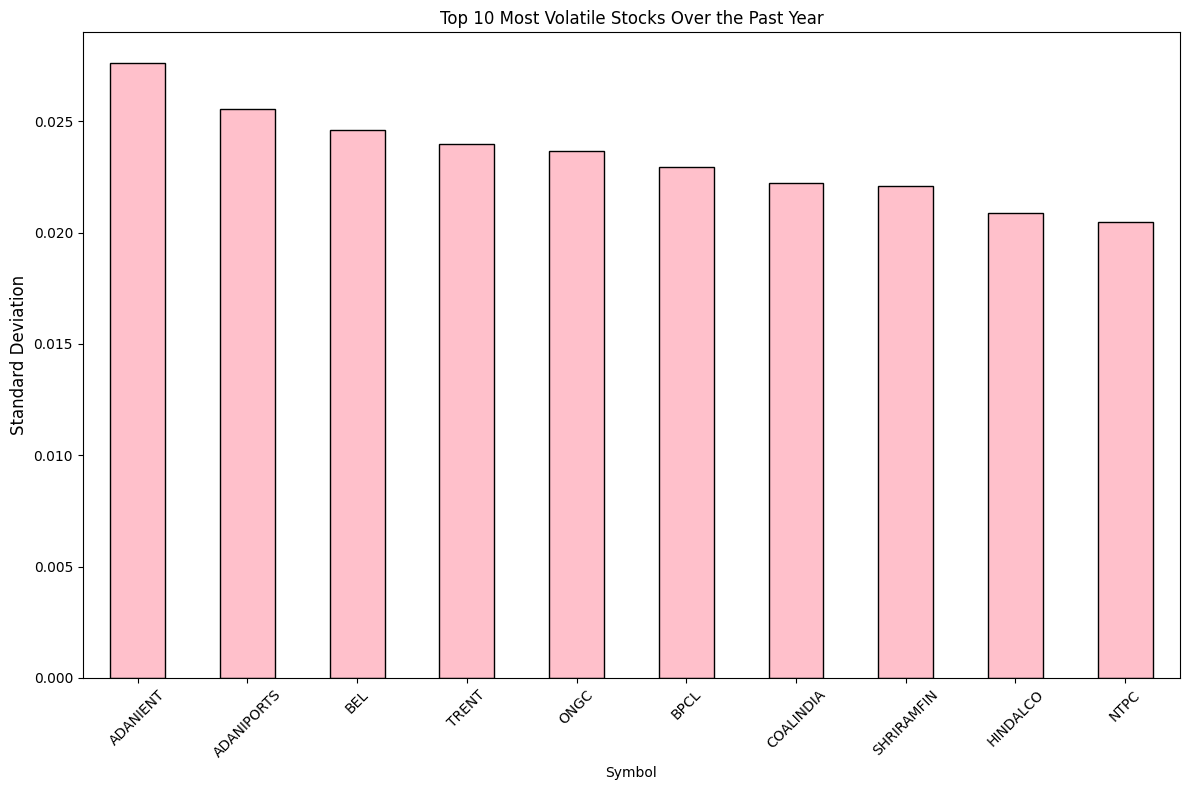

In [5]:
def calculate_volatility(output_path, save_path="top_10_volatility.csv"):
    volatility_data = []

    #processing each stock file in the output directory
    for file_name in [f for f in os.listdir(output_path) if f.endswith('.csv')]:
        stock_data = pd.read_csv(os.path.join(output_path, file_name))

        #check if 'date' column exists, if not, print an error message
        if 'date' not in stock_data.columns:
            print(f"Error: 'date' column not found in {file_name}. Available columns: {stock_data.columns}")
            continue
        
        stock_data['date'] = pd.to_datetime(stock_data['date'], errors='coerce')
        
        #filtering data for the past year
        stock_data = stock_data[stock_data['date'] >= pd.Timestamp.now() - pd.DateOffset(years=1)]
        
        #skipping empty data after filtering
        if stock_data.empty:
            print(f"No data available for the last year in {file_name}. Skipping.")
            continue
        
        #calculating daily return and volatility
        daily_returns = stock_data['close'].pct_change().dropna()
        volatility_data.append({'Symbol': file_name[:-4], 'Standard Deviation': daily_returns.std()})

    #creating dataframe and sorting by volatility
    top_10_volatility = pd.DataFrame(volatility_data).sort_values('Standard Deviation', ascending=False).head(10)
    
    #saving to CSV
    top_10_volatility.to_csv(save_path, index=False)
    print(f"Top 10 most volatile stocks saved to {save_path}")
    
    return top_10_volatility

def visualize_volatility(top_10_volatility):
    top_10_volatility.plot(
        kind='bar', x='Symbol', y='Standard Deviation', color='pink', edgecolor='black',
        figsize=(12, 8), legend=False, title='Top 10 Most Volatile Stocks Over the Past Year'
    )
    plt.xticks(rotation=45, fontsize=10)
    plt.ylabel('Standard Deviation', fontsize=12)
    plt.tight_layout()
    plt.show()

save_path = "top_10_volatility.csv"  
top_10_volatility = calculate_volatility(output_path, save_path)
visualize_volatility(top_10_volatility)

2 . CUMLATIVE RETURN OVER TIME

Cumulative return data saved to cumulative_return.csv


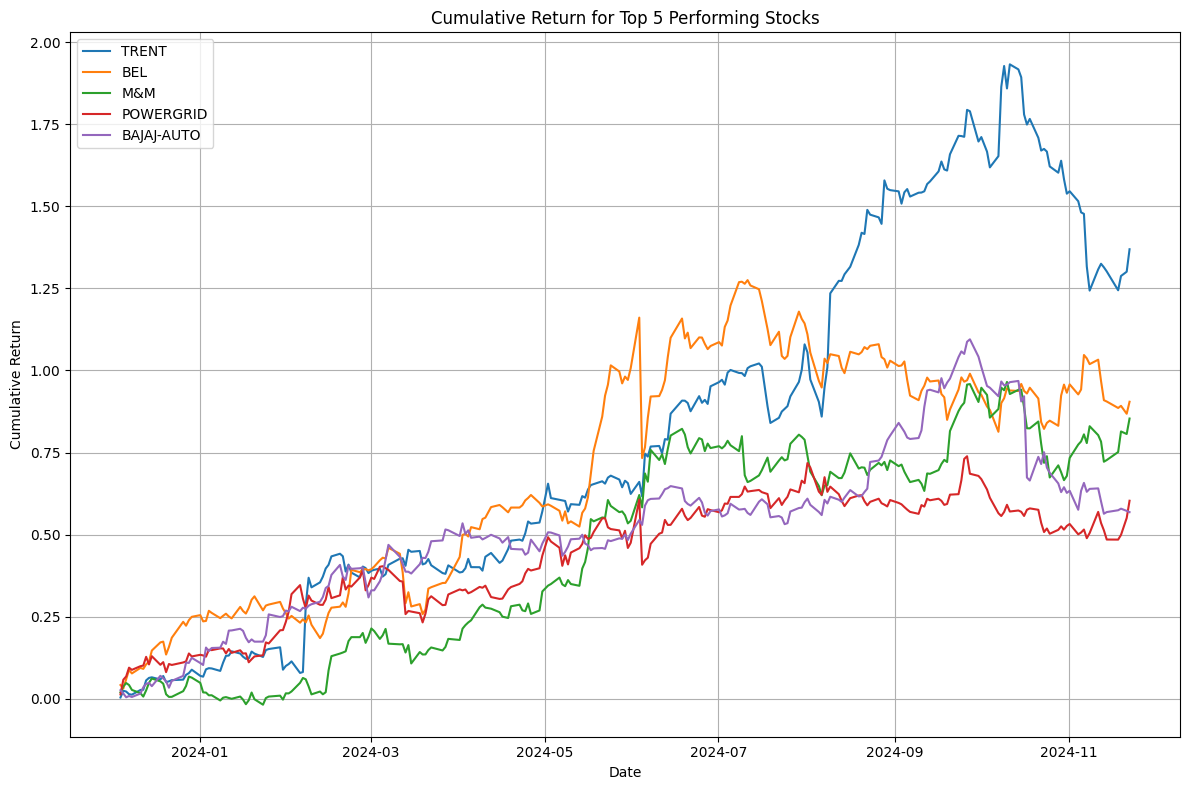

In [6]:
def calculate_cumulative_return(output_path, save_path="cumulative_return.csv"):
    cumulative_returns = []
    return_trends = {}

    #processing each stock file in the directory
    for file_name in [f for f in os.listdir(output_path) if f.endswith('.csv')]:
        file_path = os.path.join(output_path, file_name)
        stock_data = pd.read_csv(file_path)
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_data = stock_data.sort_values('date')

        #calculating daily and cumulative return
        stock_data['cumulative_return'] = (1 + stock_data['close'].pct_change()).cumprod() - 1
        ticker = file_name[:-4] 
        cumulative_returns.append({'Ticker': ticker, 'Cumulative Return': stock_data['cumulative_return'].iloc[-1]})
        return_trends[ticker] = stock_data[['date', 'cumulative_return']]

    #getting top 5 stocks by cumulative return
    top_5 = pd.DataFrame(cumulative_returns).sort_values('Cumulative Return', ascending=False).head(5)
    
    #saving the cumulative return data to a CSV file
    top_5.to_csv(save_path, index=False)
    print(f"Cumulative return data saved to {save_path}")
    
    return top_5, return_trends

def visualize_cumulative_return(top_5, return_trends):
    plt.figure(figsize=(12, 8))
    for ticker in top_5['Ticker']:
        data = return_trends[ticker]
        plt.plot(data['date'], data['cumulative_return'], label=ticker)
    plt.xlabel('Date'), plt.ylabel('Cumulative Return')
    plt.title('Cumulative Return for Top 5 Performing Stocks')
    plt.legend(), plt.grid(True), plt.tight_layout()
    plt.show()

save_path = "cumulative_return.csv" 
top_5_stocks, trends = calculate_cumulative_return(output_path, save_path)
visualize_cumulative_return(top_5_stocks, trends)

3 . SECTOR PERFORMANCE

Sector performance saved to sector_performance.csv


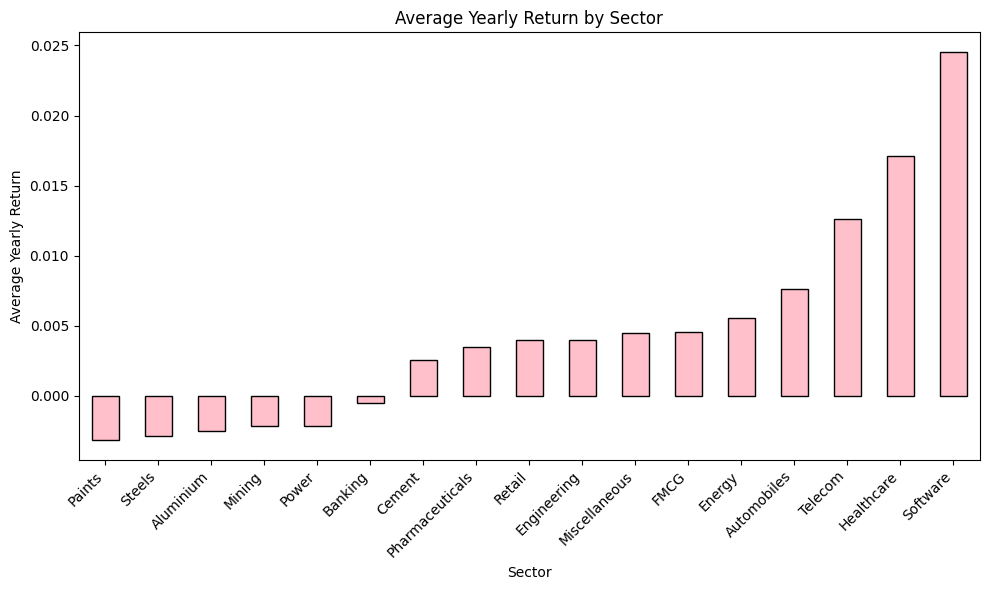

In [7]:
def calculate_sector_performance(output_path, save_csv_path="sector_performance.csv"):
    # Sector mapping for stocks
    sector_mapping = {
        'ADANIENT': 'Energy', 'TCS': 'Software', 'INFY': 'Software',
        'HDFCBANK': 'Banking', 'RELIANCE': 'Energy',
        'HDFC': 'Finance', 'ITC': 'FMCG', 'MARUTI': 'Automobiles',
        'BAJAJFINANCE': 'Finance', 'BHARTIARTL': 'Telecom', 'HINDALCO': 'Aluminium',
        'M&M': 'Automobiles', 'NTPC': 'Power', 'ULTRACEMCO': 'Cement',
        'DRREDDY': 'Pharmaceuticals', 'ASIANPAINT': 'Paints', 'TATASTEEL': 'Steels',
        'LUPIN': 'Pharmaceuticals', 'COALINDIA': 'Mining', 'INFOSYS': 'Software',
        'ACC': 'Cement', 'HCLTECH': 'Software', 'PIDILITE': 'FMCG',
        'MARICO': 'FMCG', 'SUNPHARMA': 'Pharmaceuticals', 'GAIL': 'Energy',
        'INDUSIND': 'Banking', 'EXIDEIND': 'Engineering', 'BAJAJ-AUTO': 'Automobiles',
        'TATAMOTORS': 'Automobiles', 'WIPRO': 'Software', 'BAJAJCONSUMER': 'FMCG',
        'TITAN': 'Retail', 'SBIN': 'Banking', 'DRREDDY': 'Pharmaceuticals',
        'JUBLFOOD': 'Foods & Tobacco', 'HINDUNILVR': 'FMCG', 'IOCL': 'Energy',
        'LT': 'Engineering', 'APOLLOHOSP': 'Healthcare', 'RELIANCEIND': 'Energy'
        }

    #aggregating stock data with sector assignment
    data = pd.concat(
        [
            pd.read_csv(os.path.join(output_path, file)).assign(
                Ticker=file[:-4], 
                Sector=lambda x: sector_mapping.get(file[:-4], 'Miscellaneous') 
            )
            for file in os.listdir(output_path) if file.endswith('.csv')
        ],
        ignore_index=True
    )

    #filtering valid sector and calculate yearly return
    data = data[data['Sector'].notna()]
    data['Yearly Return'] = data['close'].pct_change()

    #calculating average yearly return by sector
    sector_avg_returns = data.groupby('Sector')['Yearly Return'].mean()

    #saving sector performance to a CSV file
    sector_avg_returns.to_csv(save_csv_path, header=['Average Yearly Return'])
    print(f"Sector performance saved to {save_csv_path}")

    return sector_avg_returns

def visualize_sector_performance(sector_avg_returns):
    sector_avg_returns.sort_values().plot(kind='bar', color='pink', edgecolor='black', figsize=(10, 6))
    plt.title('Average Yearly Return by Sector')
    plt.xlabel('Sector')
    plt.ylabel('Average Yearly Return')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

sector_avg_returns = calculate_sector_performance(output_path, save_csv_path="sector_performance.csv")
visualize_sector_performance(sector_avg_returns)

4 . CORRELATION MATRIX

Correlation matrix saved to stock_correlation.csv


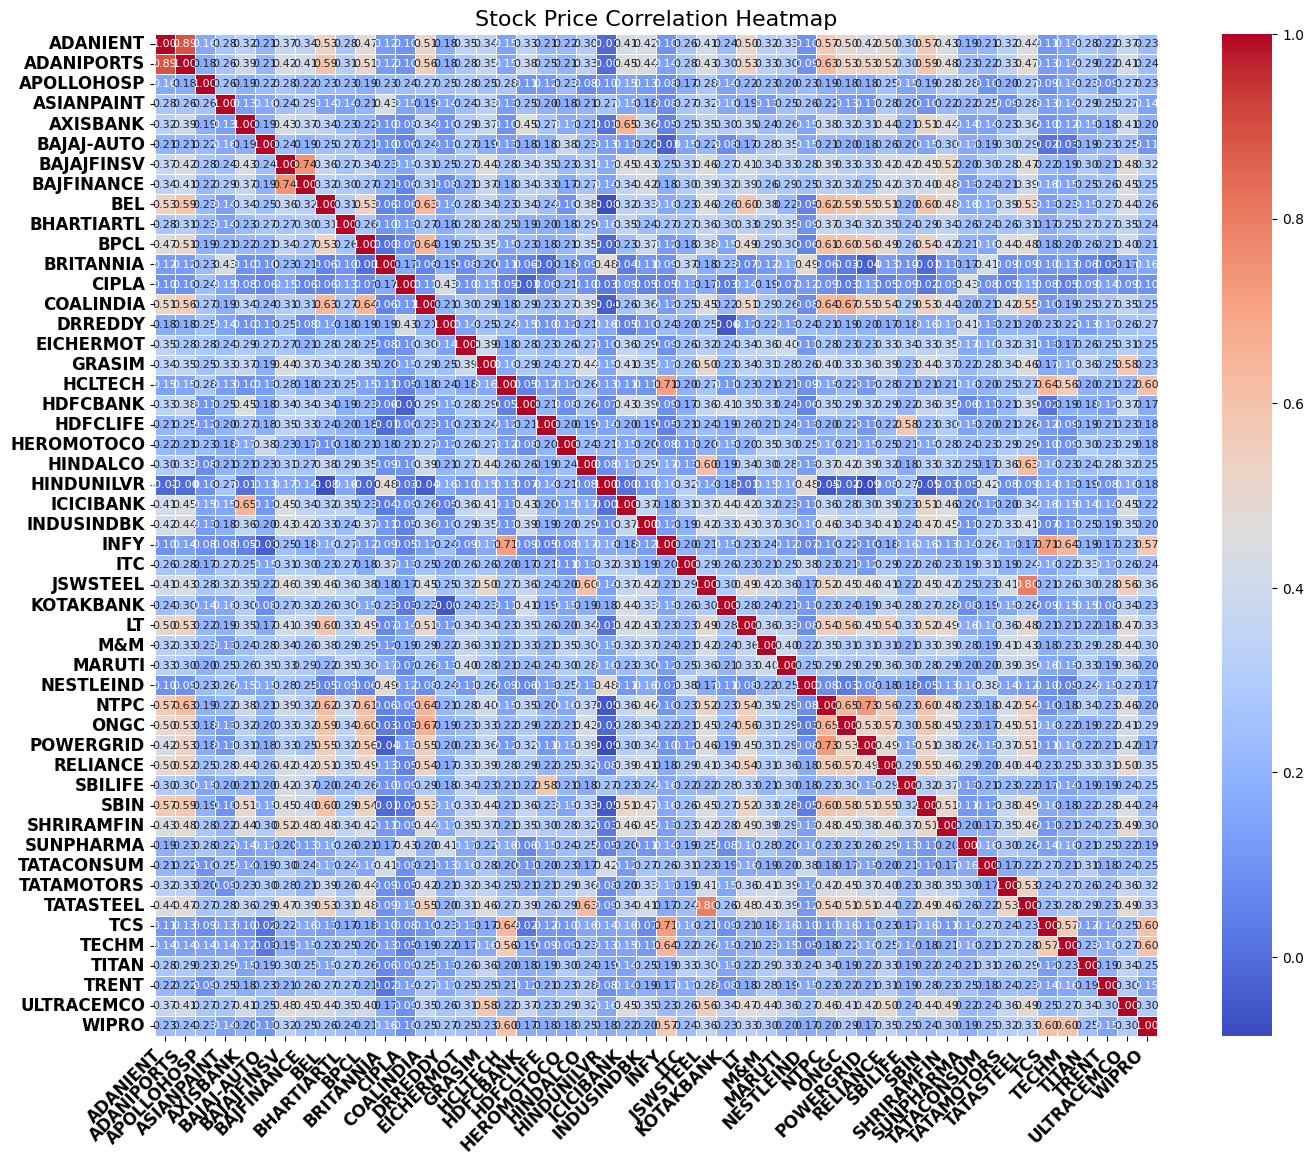

In [8]:
def calculate_correlation_matrix(output_path, save_csv_path="stock_correlation.csv"):
    #loading and combining closing price from all stock files
    stock_data = {}
    for file in os.listdir(output_path):
        if file.endswith('.csv'):
            # Read stock data
            df = pd.read_csv(os.path.join(output_path, file))
            ticker = file.replace('.csv', '')
            
            #ensuring the date is parsed correctly
            df['date'] = pd.to_datetime(df['date'])
            
            #using closing price
            stock_data[ticker] = df.set_index('date')['close']

    #creating a dataframe with closing prices 
    combined_data = pd.DataFrame(stock_data)

    #calculating the percentage change to standardize
    combined_data_pct_change = combined_data.pct_change()

    #computing the correlation matrix
    correlation_matrix = combined_data_pct_change.corr()

    #saving the correlation matrix as a CSV file
    correlation_matrix.to_csv(save_csv_path)
    print(f"Correlation matrix saved to {save_csv_path}")

    return correlation_matrix

def visualize_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(15,12))
    sns.heatmap(
        correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm",
        cbar=True, square=True, linewidths=0.5, annot_kws={"size": 8}
    )
    plt.title("Stock Price Correlation Heatmap", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.tight_layout(pad=2.0)
    plt.show()

correlation_csv_path = "stock_correlation.csv"

#calculating and saving correlation matrix
correlation_matrix = calculate_correlation_matrix(output_path, save_csv_path=correlation_csv_path)

#visualizing the correlation matrix
visualize_correlation_matrix(correlation_matrix)

5 . TOP GAINERS AND LOSERS

Gainers and Losers saved to gainers_and_losers.csv


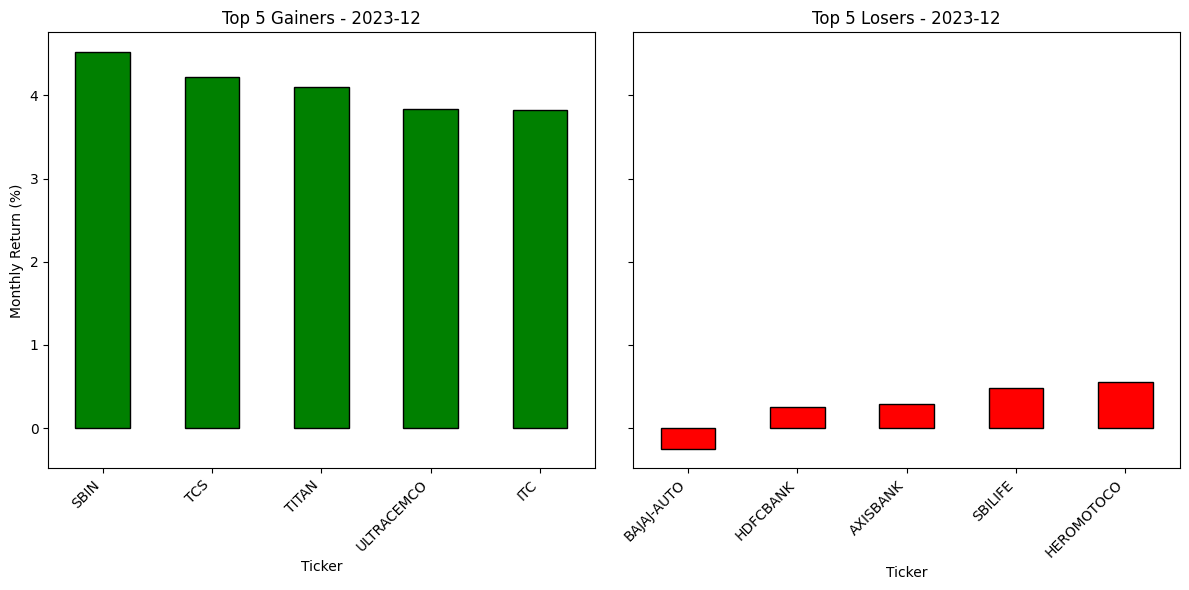

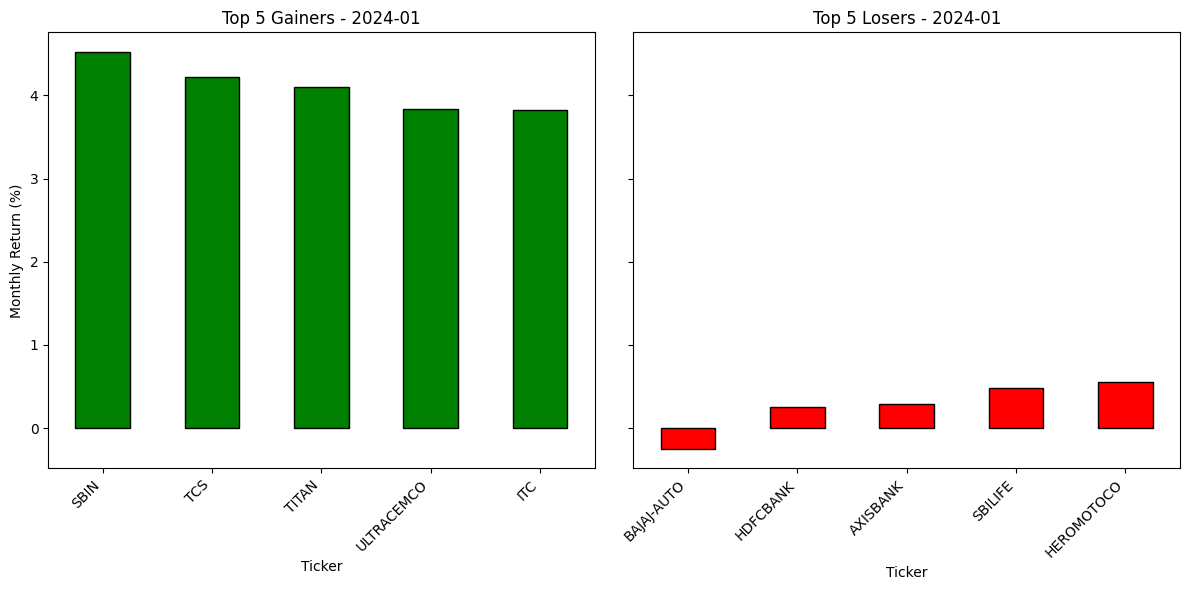

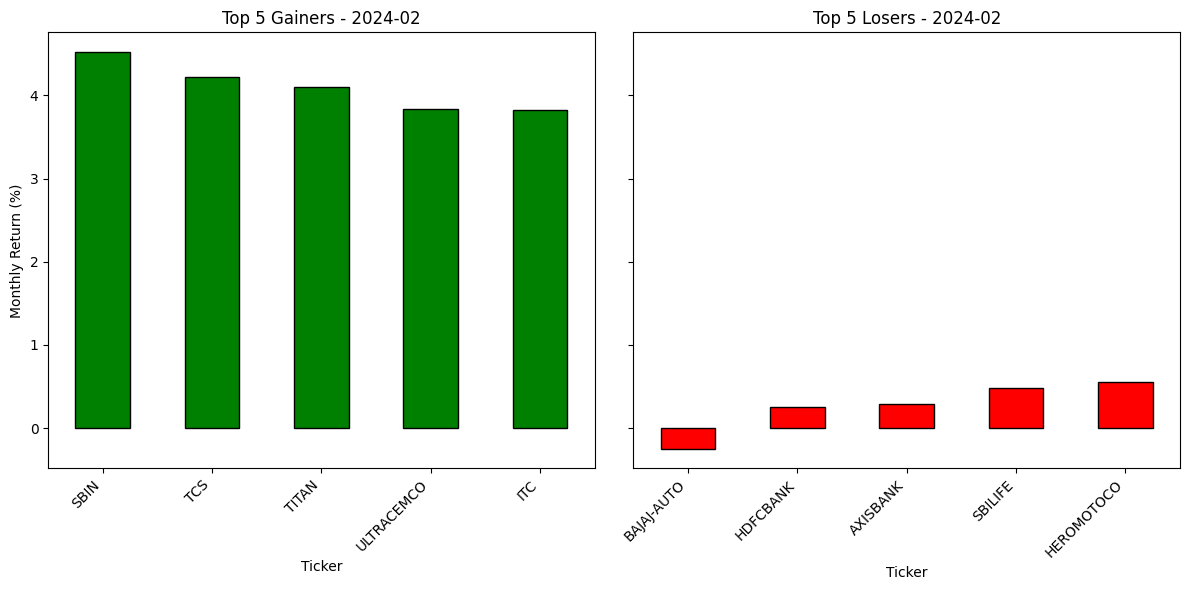

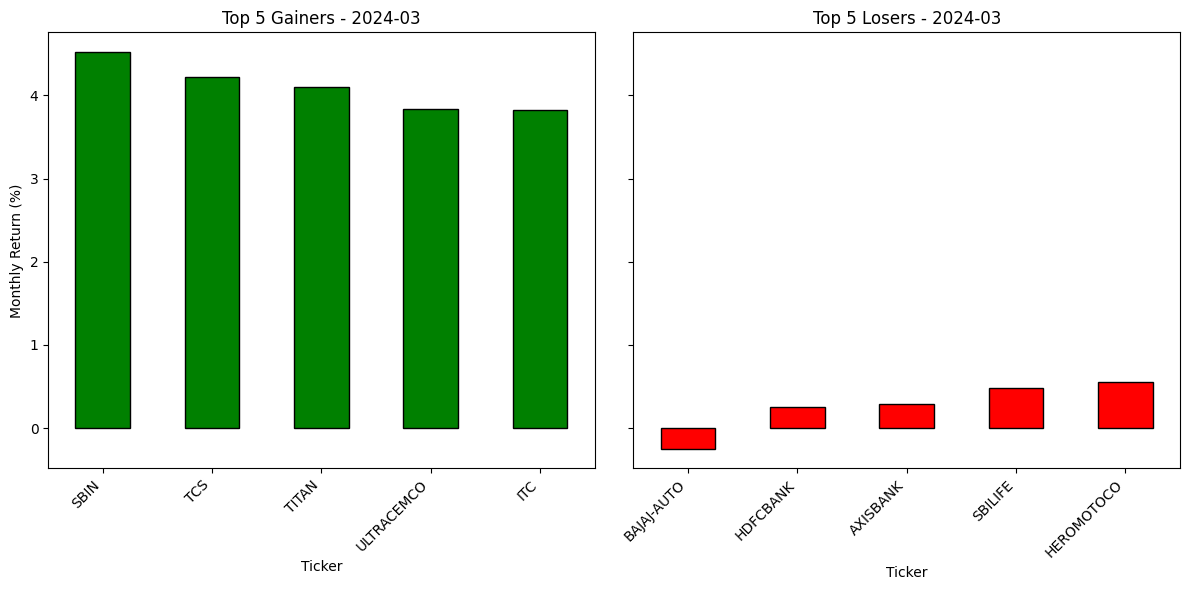

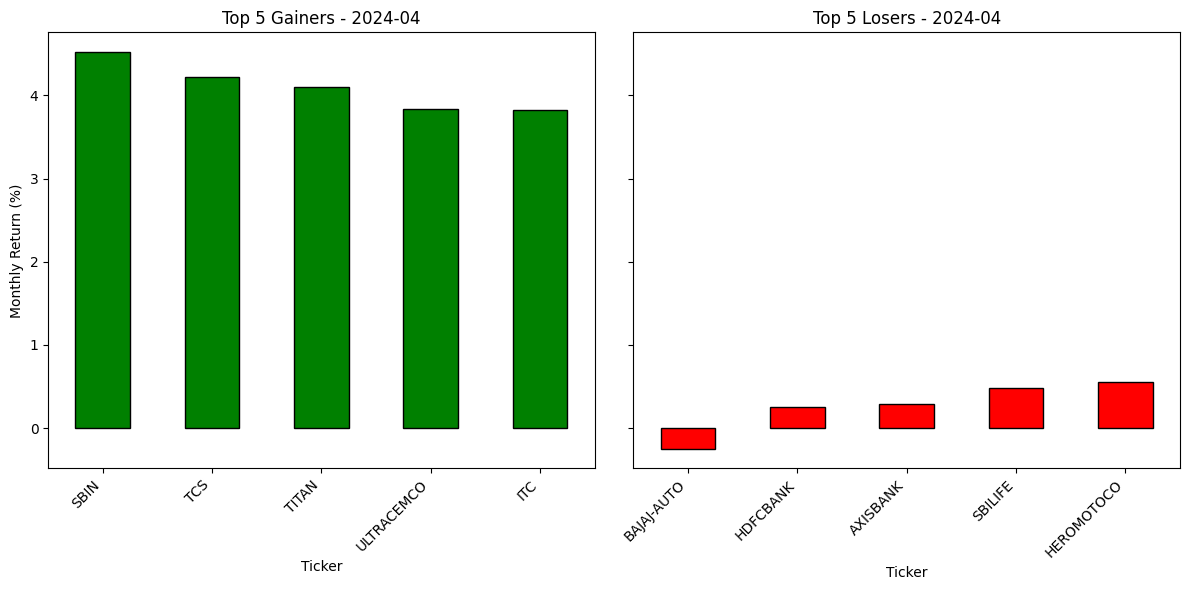

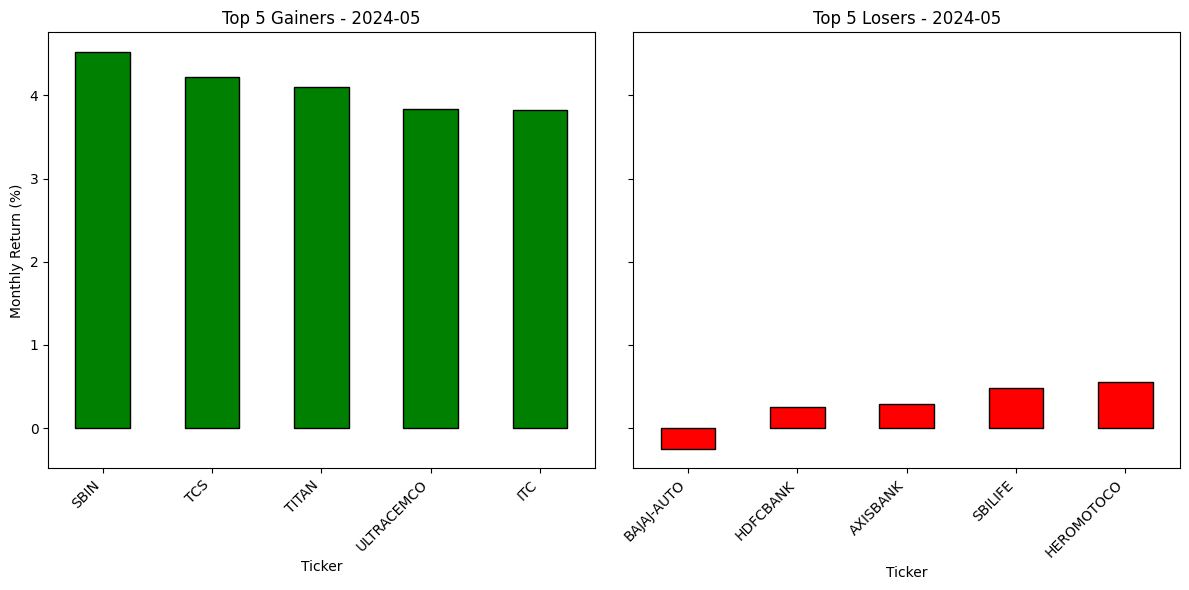

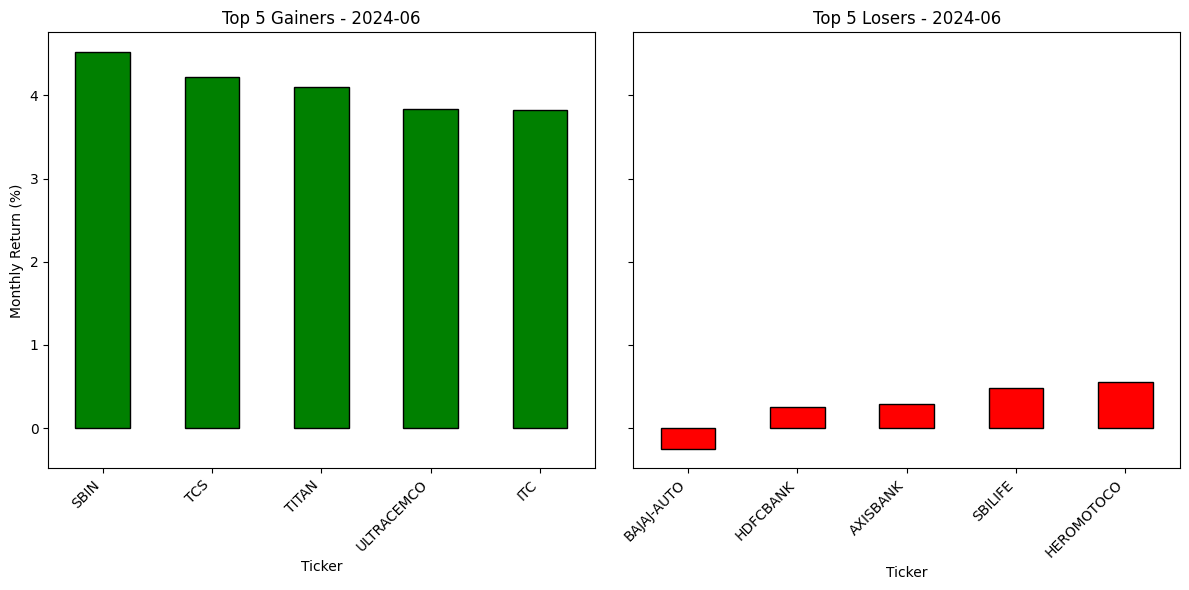

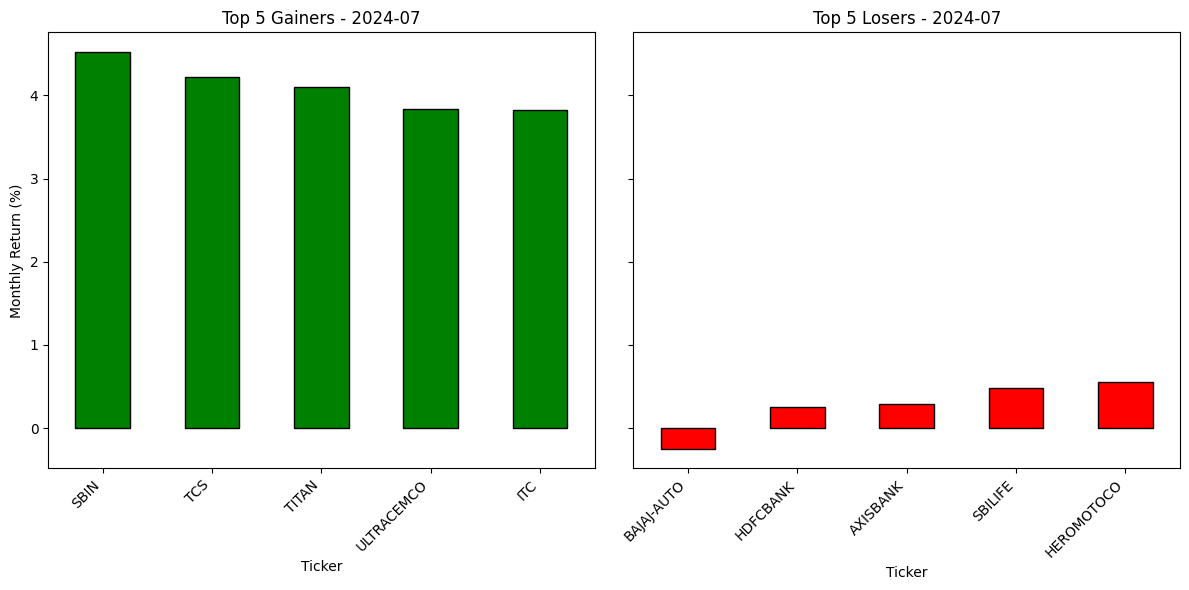

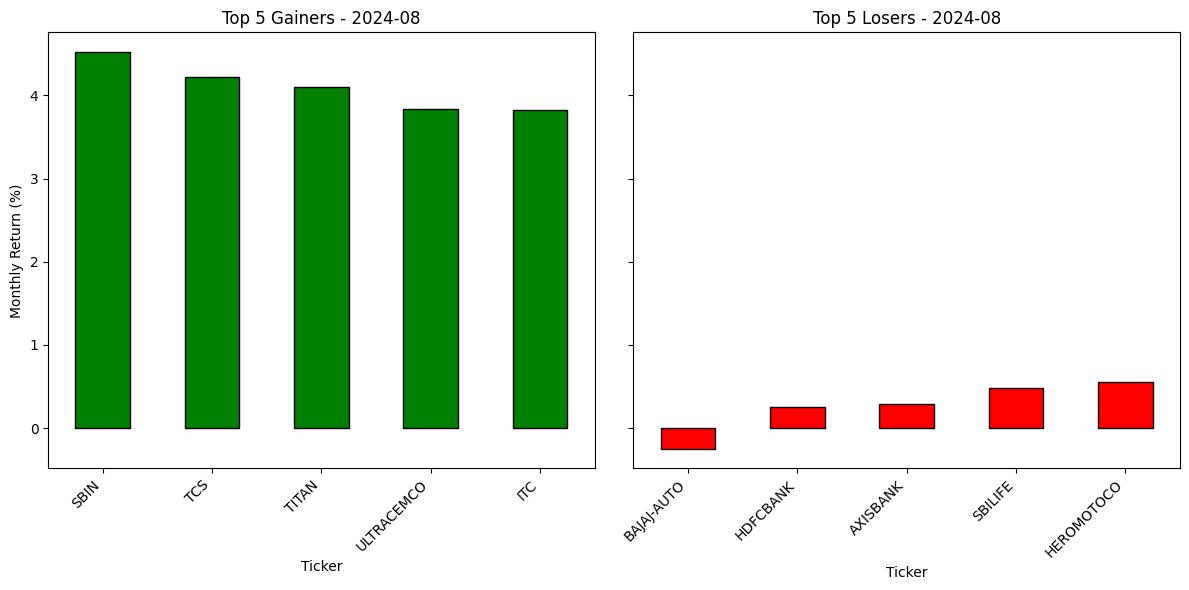

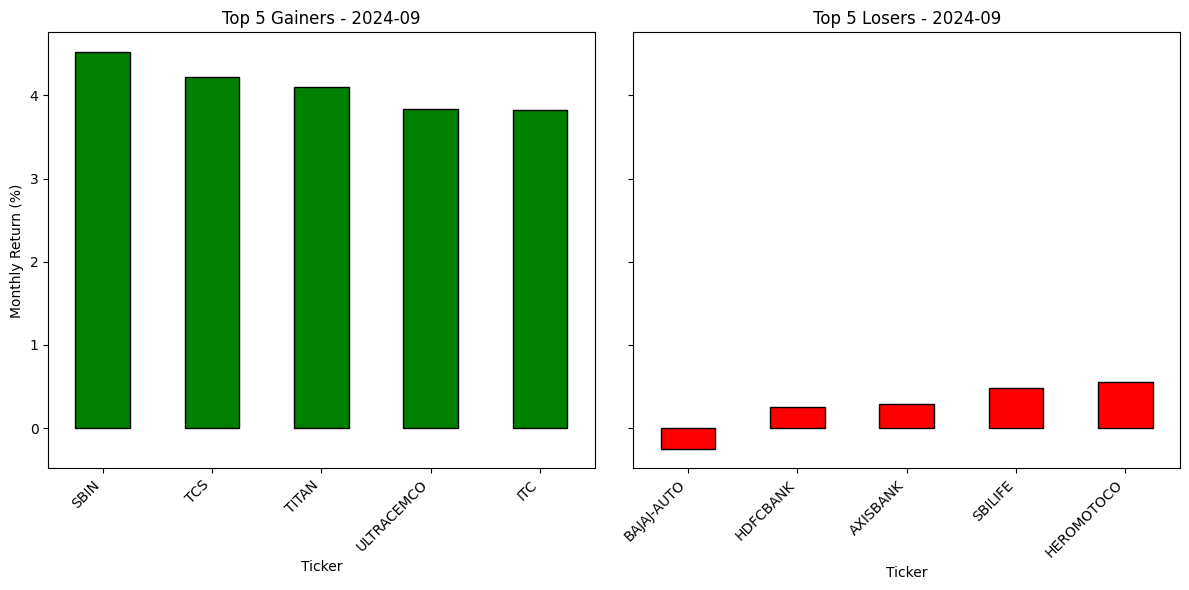

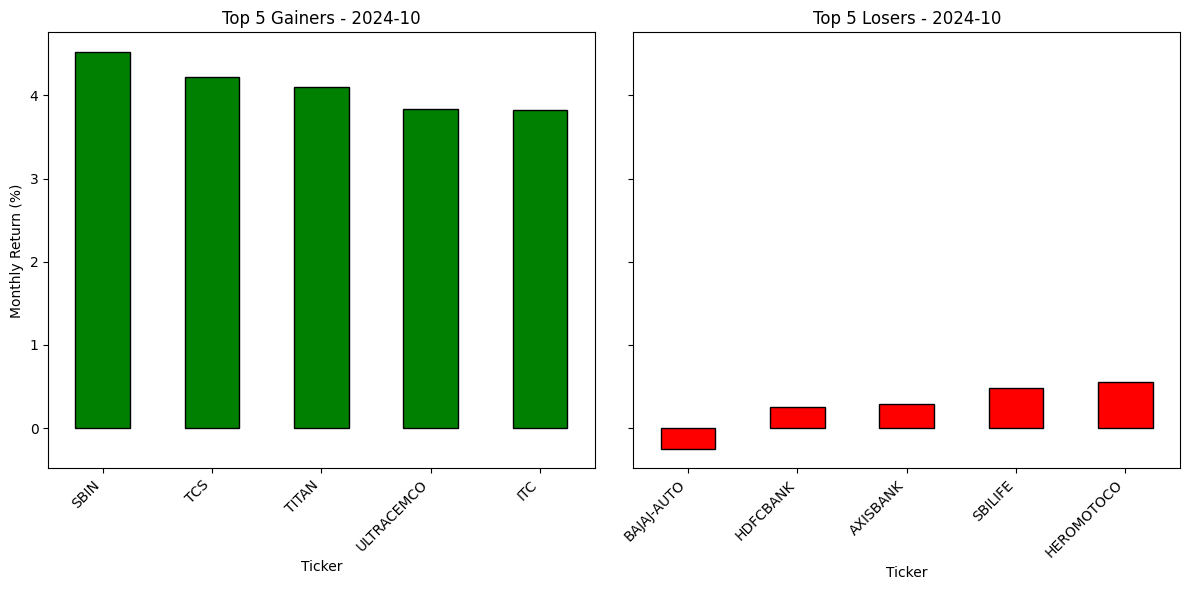

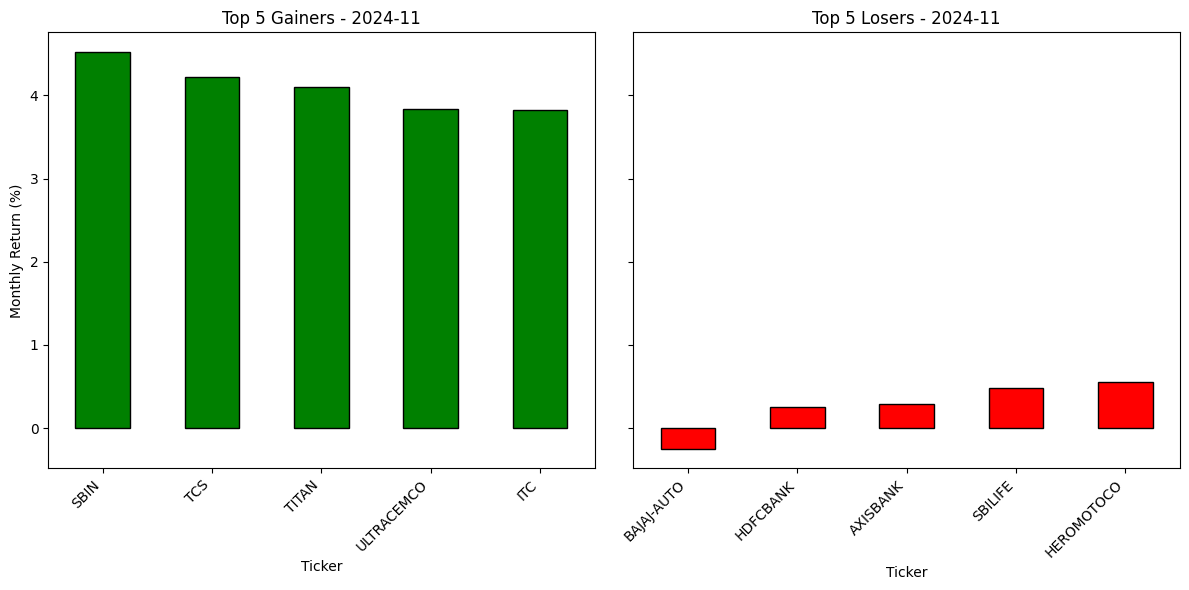

In [9]:
def top_gainers_and_losers_monthwise(output_path, save_csv_path="gainers_and_losers.csv"):
    #loading and processing stock data
    stock_data = pd.concat(
        [
            pd.read_csv(os.path.join(output_path, file)).assign(
                Ticker=file.replace('.csv', ''), 
                Date=lambda df: pd.to_datetime(df['date'])
            )
            for file in os.listdir(output_path) if file.endswith('.csv')
        ],
        ignore_index=True
    )
    stock_data['YearMonth'] = stock_data['Date'].dt.to_period('M')
    stock_data['Monthly Return'] = stock_data.groupby('Ticker')['close'].pct_change() * 100

    #identifying top gainer and loser
    results = []
    for period, data in stock_data.groupby('YearMonth'):
        gainers = data.groupby('Ticker')['Monthly Return'].last().nlargest(5)
        losers = data.groupby('Ticker')['Monthly Return'].last().nsmallest(5)

        for ticker, return_value in gainers.items():
            results.append({'YearMonth': str(period), 'Type': 'Gainer', 'Ticker': ticker, 'Return (%)': return_value})
        for ticker, return_value in losers.items():
            results.append({'YearMonth': str(period), 'Type': 'Loser', 'Ticker': ticker, 'Return (%)': return_value})

    #converting result to dataframe and saving to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(save_csv_path, index=False)
    print(f"Gainers and Losers saved to {save_csv_path}")

    #returning structured data for visualization
    top_gainers_losers = {
        period: {
            'Gainers': gainers,
            'Losers': losers,
        }
        for period, data in stock_data.groupby('YearMonth')
    }
    return top_gainers_losers

def visualize_top_gainers_and_losers(top_gainers_losers):
    for month, data in top_gainers_losers.items():
        fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

        #gainer
        data['Gainers'].plot(kind='bar', ax=axes[0], color='green', edgecolor='black')
        axes[0].set_title(f'Top 5 Gainers - {month}', fontsize=12)
        axes[0].set_ylabel('Monthly Return (%)')
        axes[0].set_xticklabels(data['Gainers'].index, rotation=45, ha='right')

        #loser
        data['Losers'].plot(kind='bar', ax=axes[1], color='red', edgecolor='black')
        axes[1].set_title(f'Top 5 Losers - {month}', fontsize=12)
        axes[1].set_xticklabels(data['Losers'].index, rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

#executing and visualizing
top_gainers_losers = top_gainers_and_losers_monthwise(output_path, save_csv_path="gainers_and_losers.csv")
visualize_top_gainers_and_losers(top_gainers_losers)

CSV FILES TO SQL

In [10]:
def store_csv_to_mysql(csv_files, table_names, host, user, password, database):
    if len(csv_files) != len(table_names):
        raise ValueError("Number of CSV files and table names must match.")
    
    #connecting to the MySQL database
    conn = mysql.connector.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )
    cursor = conn.cursor()

    for csv_file, table_name in zip(csv_files, table_names):
        #reading CSV into a pandas dataframe
        data = pd.read_csv(csv_file)

        #creating table if it doesn't exist
        columns = ", ".join([f"`{col}` TEXT" for col in data.columns])
        create_table_query = f"CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})"
        cursor.execute(create_table_query)

        #inserting data into the table
        for _, row in data.iterrows():
            placeholders = ", ".join(["%s"] * len(row))
            insert_query = f"INSERT INTO `{table_name}` VALUES ({placeholders})"
            cursor.execute(insert_query, tuple(row))

        print(f"Data from {csv_file} stored in table {table_name}")

    #committing change and closing the connection
    conn.commit()
    conn.close()
    print("All data stored successfully in the database.")

csv_files = [
    "top_10_volatility.csv", "cumulative_return.csv", "sector_performance.csv", "stock_correlation.csv", "gainers_and_losers.csv"
]
table_names = [
    "table1", "table2", "table3", "table4", "table5"
]

store_csv_to_mysql(
    csv_files=csv_files,
    table_names=table_names,
    host="localhost",
    user="root",
    password="root",
    database="stockmarket"
)

Data from top_10_volatility.csv stored in table table1
Data from cumulative_return.csv stored in table table2
Data from sector_performance.csv stored in table table3
Data from stock_correlation.csv stored in table table4
Data from gainers_and_losers.csv stored in table table5
All data stored successfully in the database.
